In [341]:
import torch
import utils
import torch
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
from utils.dataset_cached import setup_data_loaders, CELEBA_EASY_LABELS
from utils.dataset_cached import CELEBACached
import utils.dataset_cached as dc
import argparse
from models.ccvae import CCVAE
import numpy as np
import os
import pandas as pd
from ss_vae import parser_args
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy.stats import entropy

# Load DataSet and Model

In [143]:
loaders = dc.setup_data_loaders(False, 1, root="./data/datasets/", download=False)
im_shape = (3, 64, 64)
cc_vae = CCVAE(z_dim=45,
                   num_classes=len(CELEBA_EASY_LABELS),
                   im_shape=im_shape,
                   use_cuda=False,
                   prior_fn=loaders['test'].dataset.prior_fn)

Splitting Dataset


In [144]:
len(loaders['sup'].dataset.attr[1])

40

In [145]:
CELEBA_EASY_LABELS

['Arched_Eyebrows',
 'Bags_Under_Eyes',
 'Bangs',
 'Black_Hair',
 'Blond_Hair',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Eyeglasses',
 'Heavy_Makeup',
 'Male',
 'No_Beard',
 'Pale_Skin',
 'Receding_Hairline',
 'Smiling',
 'Wavy_Hair',
 'Wearing_Necktie',
 'Young']

In [146]:
set(loaders['sup'].dataset.attr_names).intersection(set(CELEBA_EASY_LABELS))

{'Arched_Eyebrows',
 'Bags_Under_Eyes',
 'Bangs',
 'Black_Hair',
 'Blond_Hair',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Eyeglasses',
 'Heavy_Makeup',
 'Male',
 'No_Beard',
 'Pale_Skin',
 'Receding_Hairline',
 'Smiling',
 'Wavy_Hair',
 'Wearing_Necktie',
 'Young'}

In [147]:
def extract_images_by_label(data_loader, label_to_extract):
    extracted_images = []
    labels = []

    for images, labels_batch in data_loader:
        # Iterate through the batches of the data loader
        for image, label in zip(images, labels_batch):
            # Check if the label matches the desired label
            if label.item() == label_to_extract:
                extracted_images.append(image)
                labels.append(label.item())

    return torch.stack(extracted_images), torch.tensor(labels)


In [148]:
ENCODER_PATH = './data/output/encoder.pt'
DECODER_PATH = './data/output/decoder.pt'
COND_PRIOR_PATH = './data/output/cond_prior.pt'
CLASSIFIER_PATH = './data/output/classifier.pt'

In [149]:
# Load weights for the encoder
encoder_checkpoint = torch.load(ENCODER_PATH)
cc_vae.encoder.load_state_dict(encoder_checkpoint.state_dict())

# Load weights for the decoder
decoder_checkpoint = torch.load(DECODER_PATH)
cc_vae.decoder.load_state_dict(decoder_checkpoint.state_dict())

# Load weights for the classifier
classifier_checkpoint = torch.load(CLASSIFIER_PATH)
cc_vae.classifier.load_state_dict(classifier_checkpoint.state_dict())

# Load weights for the conditional prior
cond_prior_checkpoint = torch.load(COND_PRIOR_PATH)
cc_vae.cond_prior.load_state_dict(cond_prior_checkpoint.state_dict())

# Make sure to set each component to evaluation mode if needed
cc_vae.encoder.eval()
cc_vae.decoder.eval()
cc_vae.classifier.eval()
cc_vae.cond_prior.eval()

CondPrior()

## **1. Inference :**

**Reconstruct Images**

In [150]:
img_batch = CELEBACached.fixed_imgs
reconstructed_img_batch = cc_vae.reconstruct_img(img_batch).view(-1, *im_shape)

In [151]:
img_idx =25
img = img_batch[img_idx,:,:,:]
reconstructed_img = reconstructed_img_batch[img_idx,:,:,:]

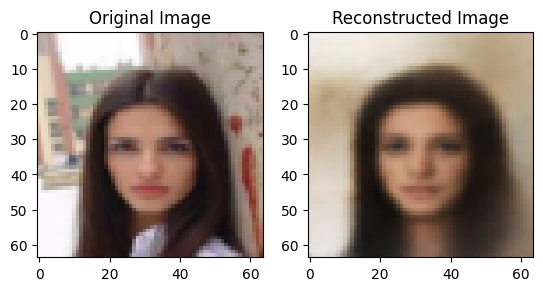

In [152]:
to_pil = transforms.ToPILImage()
image_pil = to_pil(img)
reconstructed_pil = to_pil(reconstructed_img)

# Plot the original image on the left
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title('Original Image')

# Plot the reconstructed image on the right
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_pil)
plt.title('Reconstructed Image')

# Display the plots
plt.show()

**Generate Images**

## **2. PCA of Latent Space** : 

Steps : 
- Recuperer les locs and scales : For all Labels
- PCA on these labels 

In [201]:
cc_vae.encoder(CELEBACached.fixed_imgs)[0]

tensor([[  3.2688,  -5.2063, -22.4231,  ...,  -1.3065,  -1.7041,  -2.1761],
        [ -2.6196,   6.4164, -17.7175,  ...,   2.1084,  -0.7429,   2.2341],
        [ -5.1831,   0.5985, -22.2608,  ...,  -0.7976,  -1.6692,   1.7614],
        ...,
        [  1.4204, -16.1922,  15.8405,  ...,   3.2487,  -0.9543,   0.7988],
        [  4.5392,  -3.6997,  -2.6981,  ...,   0.3035,   1.8307,   0.9862],
        [ -4.9690,   5.2663,  -9.0098,  ...,  -0.6601,   1.3110,   1.1635]],
       grad_fn=<AddmmBackward>)

In [219]:
output_list = []
with torch.no_grad():
    for i, (images, _) in enumerate(loaders['sup']):
        if i * loaders['sup'].batch_size >= 1000:
            break

        # Forward pass
        output = cc_vae.encoder(images)

        # Append to the list
        output_list.append(output[0].numpy())

# Convert the list to a NumPy array
latent_array = np.concatenate(output_list, axis=0)

In [220]:
np.shape(latent_array)

(1000, 45)

In [276]:
len(CELEBA_EASY_LABELS)

18

In [279]:
CELEBA_EASY_LABELS[11]

'No_Beard'

In [222]:
np.shape(latent_array)

(1000, 45)

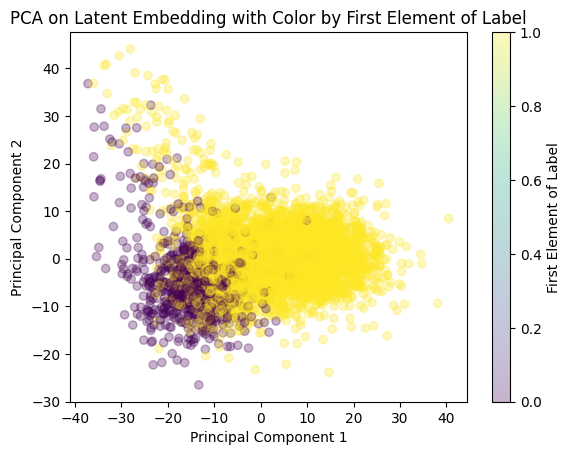

In [356]:
output_list = []
labels_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(loaders['test']):
        if i * loaders['test'].batch_size >= 5000:
            break

        # Forward pass through the encoder
        latent_embedding,latent_scale = cc_vae.encoder(images)

        # Append to the lists
        output_list.append(latent_embedding.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert the lists to NumPy arrays
latent_array = np.concatenate(output_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

#Latent_Embedding = cc_vae.encoder(CELEBACached.fixed_imgs)[0].detach().numpy()

# Perform PCA using scikit-learn
n_components = 2  # Number of components to keep
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(latent_array[:,[8,11]])

# Plot the principal components
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=labels_array[:, 11],  # Use the first element of the label as colors
    marker='o',
    alpha=0.3,
    cmap='viridis'  # You can choose another colormap if needed
)
plt.title('PCA on Latent Embedding with Color by First Element of Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='First Element of Label')
plt.show()

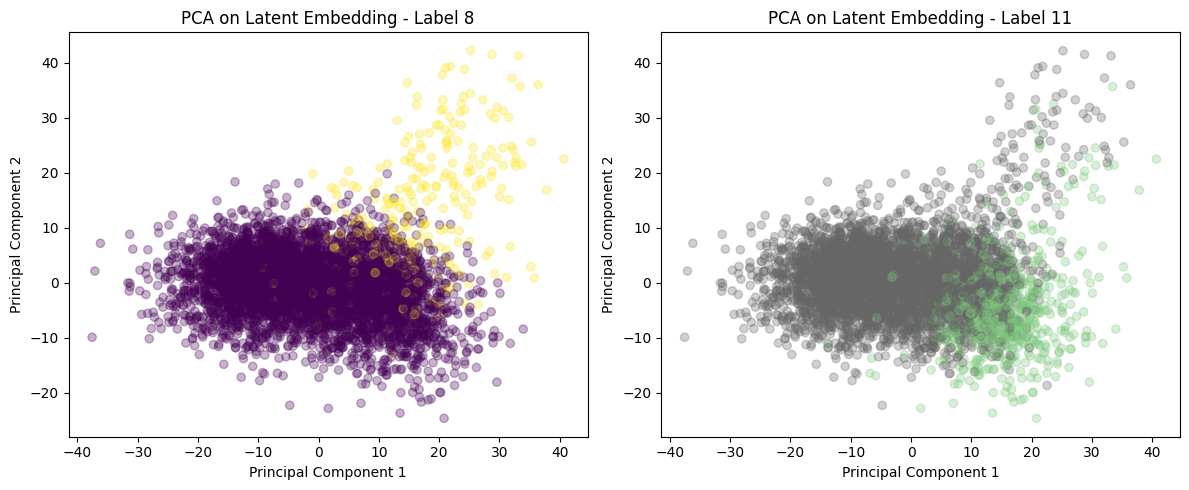

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for label 8
axes[0].scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=labels_array[:, 8],  # Use the ninth element of the label as colors
    marker='o',
    alpha=0.3,
    cmap='viridis'  # You can choose another colormap if needed
)
axes[0].set_title('PCA on Latent Embedding - Label 8')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')


# Plot for label 11
axes[1].scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=labels_array[:, 11],  # Use the twelfth element of the label as colors
    marker='o',
    alpha=0.3,
    cmap='Accent'  # You can choose another colormap if needed
)
axes[1].set_title('PCA on Latent Embedding - Label 11')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

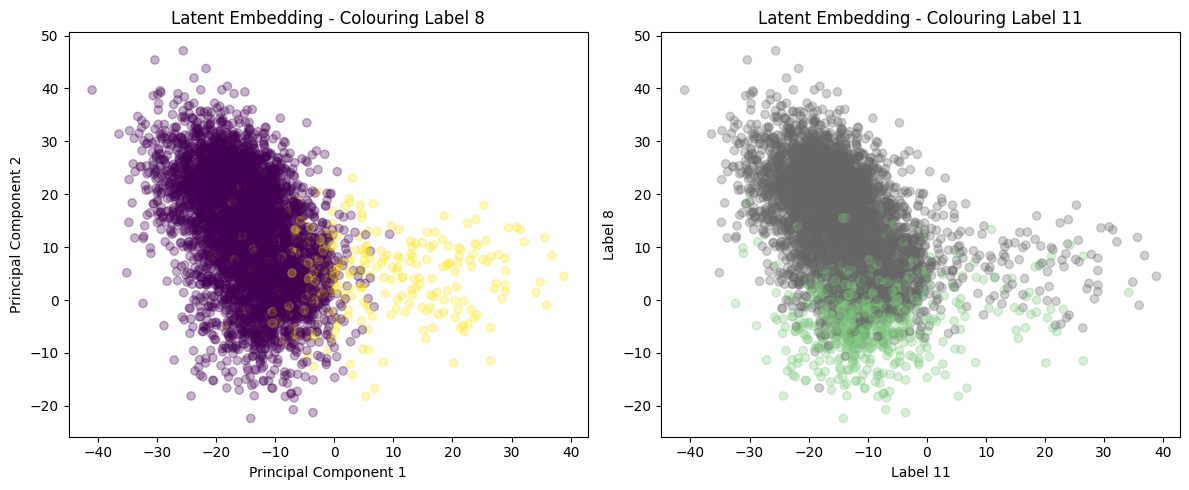

In [338]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for label 8
axes[0].scatter(
    latent_array[:, 8],
    latent_array[:, 11],
    c=labels_array[:, 8],  # Use the ninth element of the label as colors
    marker='o',
    alpha=0.3,
    cmap='viridis'  # You can choose another colormap if needed
)
axes[0].set_title('Latent Embedding - Colouring Label 8')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot for label 11
axes[1].scatter(
    latent_array[:, 8],
    latent_array[:, 11],
    c=labels_array[:, 11],  # Use the twelfth element of the label as colors
    marker='o',
    alpha=0.3,
    cmap='Accent'  # You can choose another colormap if needed
)

axes[1].set_title('Latent Embedding - Colouring Label 11')
axes[1].set_xlabel('Label 11')
axes[1].set_ylabel('Label 8')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

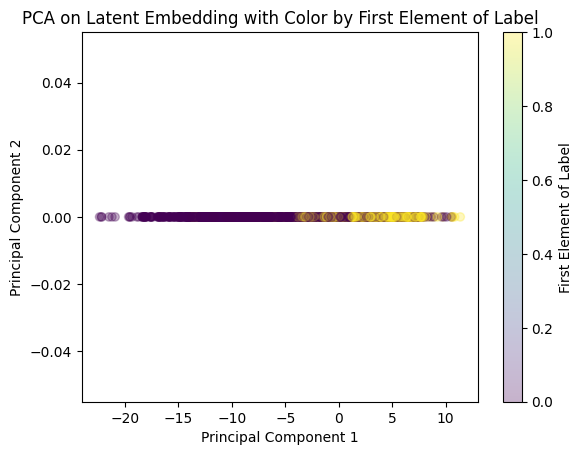

In [339]:
plt.scatter(
    latent_array[:,0],
    np.zeros_like(latent_array[:,0]),
    c=labels_array[:, 0],  # Use the first element of the label as colors
    marker='o',
    alpha=0.3,
    cmap='viridis'  # You can choose another colormap if needed
)
plt.title('PCA on Latent Embedding with Color by First Element of Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='First Element of Label')
plt.show()

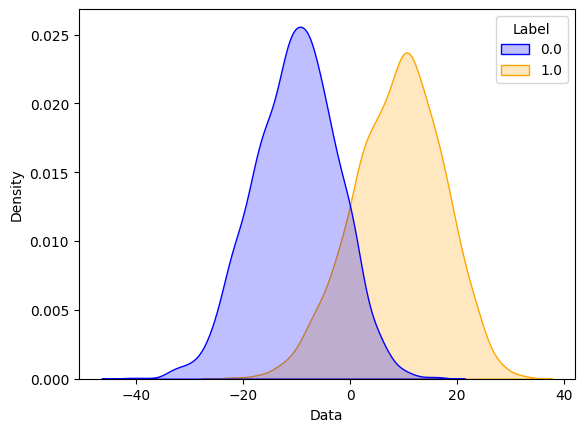

In [470]:
label_num = 14
df = pd.DataFrame({'Data': latent_array[:, label_num], 'Label': labels_array[:, label_num]})

# Create a kernel density plot with different colors based on labels
sns.kdeplot(x=df['Data'], fill=True, hue=df['Label'], palette={0: 'blue', 1: 'orange'})

# Set labels and title
#plt.xlabel('Values')
#plt.ylabel('Density')
#plt.title(f'Distribution of Latent Space Variable for the Smiling Label')

# Show the plot
plt.show()

In [466]:
CELEBA_EASY_LABELS[14]

'Smiling'

In [208]:
loaders['sup']

## **3. KL Divergence:** : 

In [403]:
wass_distance = []
for label_idx in range(18): 
    embedding = pd.DataFrame(latent_array)
    labels = pd.DataFrame(labels_array)
    mask0 = labels[label_idx]==0
    mask1 = labels[label_idx]==1
    P = embedding[mask0][label_idx]
    Q = embedding[mask1][label_idx]
    wass_distance.append(wasserstein_distance(P,Q))

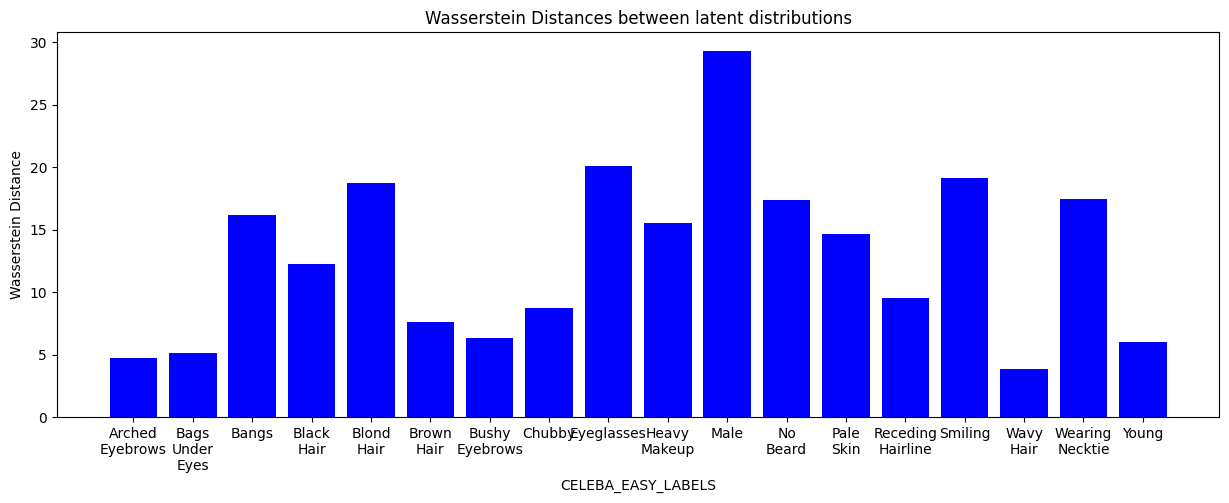

In [428]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(CELEBA_EASY_LABELS)), wass_distance, color='blue')

# Set x-axis labels with line breaks
multiline_labels = [
    '\n'.join(part for part in label.split('_'))  # Split at underscores and join with line breaks
    for label in CELEBA_EASY_LABELS
]


plt.xticks(np.arange(len(CELEBA_EASY_LABELS)), multiline_labels)


# Labeling and title
plt.xlabel('CELEBA_EASY_LABELS')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distances between latent distributions')

# Show the plot
plt.show()

Here we plotting a reduced version to include in the report

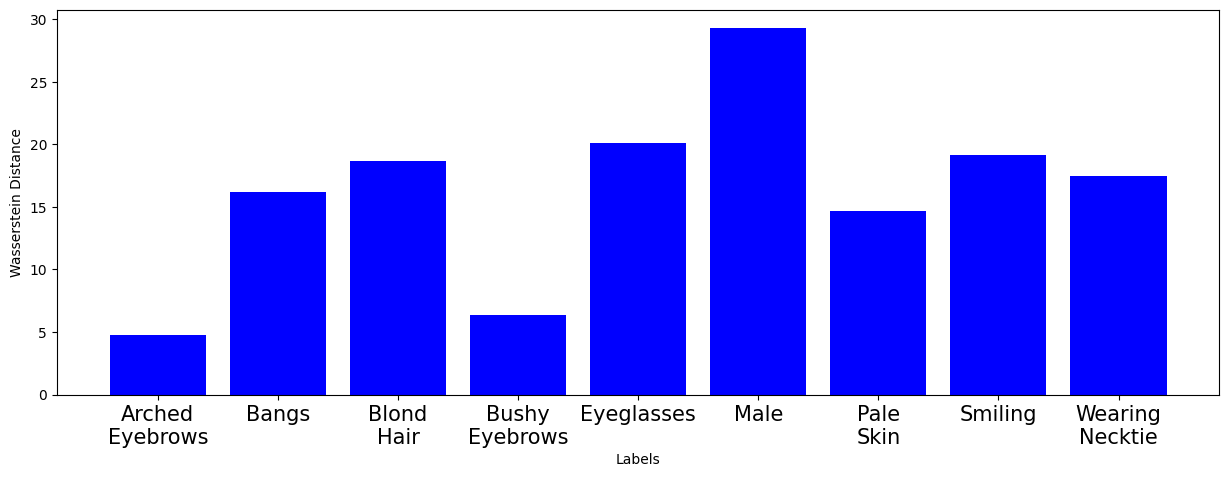

In [476]:
odd_labels = [label for i, label in enumerate(CELEBA_EASY_LABELS) if i % 2 == 0]
odd_wass_distance = [distance for i, distance in enumerate(wass_distance) if i % 2 == 0]

plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(odd_labels)), odd_wass_distance, color='blue')

# Set x-axis labels with line breaks
multiline_labels = [
    '\n'.join(part for part in label.split('_'))  # Split at underscores and join with line breaks
    for label in odd_labels
]

plt.xticks(np.arange(len(odd_labels)), multiline_labels, fontsize=15)
plt.xticks(np.arange(len(odd_labels)), multiline_labels, fontsize=15)
# Labeling and title
plt.xlabel('Labels')
plt.ylabel('Wasserstein Distance')


# Show the plot
plt.show()

In [394]:
N_P = len(P)
N_Q = len(Q)
normalized_P = P / N_P
normalized_Q = Q / N_Q

# Compute the KL divergence
kl_divergence = np.sum(normalized_P * np.log(normalized_P / normalized_Q))
print(f"KL Divergence: {kl_divergence}")

KL Divergence: 0.0


In [395]:
wasserstein_distance(P,Q)

6.023872478348238

In [396]:
embedding = pd.DataFrame(latent_embedding)
latent =  latent_array
latent = latent_array
latent_array[0]
latent_embedding

tensor([[ -1.4717,  -3.2314,  14.4463,  -5.2405, -11.5204,  -0.3447, -10.1287,
          -4.1729, -14.1296,   2.8592,  -9.2011,  13.4579, -12.0798, -14.8606,
         -12.0069,  -4.3288, -14.6608,   3.8689,   1.5574,  -0.1951,   2.5049,
           1.0639,  -1.3654,  -0.1059,  -0.9685,   1.9040,   2.9757,  -0.7575,
           1.3397,  -1.1287,   1.1783,   0.7230,   0.0653,   1.1331,   2.3768,
          -1.0262,  -0.2673,  -1.3086,  -1.0407,  -2.1349,  -2.2277,  -1.3755,
          -0.0796,  -0.7906,   0.5224]])

## **4. Latent Walk:** : 

In [55]:
cc_vae.latent_walk(img, './data/output')

In [311]:
CELEBACached.fixed_imgs[0]

tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.7412, 0.9490, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.7961, 0.9686, 0.9882],
         [0.9922, 0.9922, 0.9922,  ..., 0.8588, 0.9804, 0.9843],
         ...,
         [0.7804, 0.7216, 0.5333,  ..., 0.4510, 0.4902, 0.5255],
         [0.6784, 0.6000, 0.5098,  ..., 0.4039, 0.3922, 0.3882],
         [0.6196, 0.7176, 0.5529,  ..., 0.4706, 0.4588, 0.4549]],

        [[0.9059, 0.9059, 0.9059,  ..., 0.6235, 0.8784, 0.9255],
         [0.9059, 0.9059, 0.9059,  ..., 0.6863, 0.9059, 0.9294],
         [0.9059, 0.9059, 0.9059,  ..., 0.7608, 0.9294, 0.9333],
         ...,
         [0.5216, 0.4588, 0.2745,  ..., 0.2235, 0.2667, 0.3098],
         [0.4196, 0.3373, 0.2431,  ..., 0.1529, 0.1490, 0.1490],
         [0.3569, 0.4471, 0.2824,  ..., 0.2000, 0.1922, 0.1922]],

        [[0.7608, 0.7608, 0.7608,  ..., 0.4392, 0.7490, 0.8667],
         [0.7608, 0.7608, 0.7608,  ..., 0.5176, 0.7961, 0.8667],
         [0.7608, 0.7608, 0.7608,  ..., 0.6196, 0.8431, 0.

In [333]:
for loader_name, data_loader in loaders.items():
    for batch in data_loader:
        item = batch[0]  # Assuming the DataLoader returns a batch with a single item

        # Compare the paths or other relevant identifiers
        if (CELEBACached.fixed_imgs[5] == item).all():
            print(f"The specific image is in {loader_name}.")
            break
    else:
        continue  # Continue to the next DataLoader if the image is not found in the current one
    break  # Break the outer loop if the image is found
else:
    print("The specific image is not in any of the DataLoaders.")

The specific image is in sup.


In [334]:
loaders

{'sup': <torch.utils.data.dataloader.DataLoader at 0x7fbff5d55f50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fbf51011150>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fbf52f63f10>}

In [328]:
np.shape((batch)[1])

torch.Size([1, 18])